In [1]:
import sys
import sklearn
import numpy as np
import os
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
# 3차원 데이터 생성

m = 60
n = 3
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2
X = np.empty((m, n))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

0 ~ 270도 사이에 있는 임의의 각도 60개를 선택한다. 그 후 아래와 같이 각도로 매개화 된 3차원의 좌표값을 만든다.

$$
\begin{cases}
X = \cos(\theta) + \frac{\sin(\theta)}{2} + \mbox{noise} \\
Y = 0.7\sin(\theta) + \mbox{noise} \\
Z = w_1 X + w_2 Y + \mbox{noise}
\end{cases}
$$

In [3]:
# 특잇값 분해로 주성분 추출

X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt.T[:, 0]
c2 = Vt.T[:, 1]
S = np.zeros(X_centered.shape)
S[:len(s), :len(s)] = np.diag(s)

주성분은 c1, c2로 구하였고 대각행렬은 S로 구하였다.

In [4]:
# 분산을 최대로 하는 주성분 2개를 이용해 2차원으로 투영하기

W2 = Vt.T[:, :2]
X2D_using_svd = X_centered.dot(W2)
X2D_using_svd[:5]

array([[-1.19510947,  0.41587338],
       [-1.30082692,  0.35284744],
       [-0.86205601, -0.26062071],
       [ 0.81634669,  0.61246857],
       [-0.25068241, -0.55308682]])

In [5]:
# PCA 라이브러리를 이용해서 구하기

from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X2D = pca.fit_transform(X)
X2D[:5]

array([[ 1.19510947,  0.41587338],
       [ 1.30082692,  0.35284744],
       [ 0.86205601, -0.26062071],
       [-0.81634669,  0.61246857],
       [ 0.25068241, -0.55308682]])

In [6]:
X3D_inv = pca.inverse_transform(X2D)
np.allclose(X3D_inv, X)

False

위의 코드에서 볼 수 있다시피 투영을 한 다음 다시 복원을 하면 원본 데이터와 차이가 발생한다.

이는 투영하는 과정에서 일부 정보를 잃어버리기 때문에 다시 원래 상태로 복원하더라도 완전하게 복원되지 않다는 것을 보여준다.

In [7]:
# 복원 과정에서 발생하는 오차

np.mean(np.sum(np.square(X3D_inv - X), axis=1))

0.008275322174068043

In [8]:
# 설명된 분산의 비율

pca.explained_variance_ratio_

array([0.88789584, 0.10425425])

In [9]:
1 - pca.explained_variance_ratio_.sum()

0.007849910984785713

설명된 분산의 비율을 통해 각 주성분의 축에 따른 데이터셋의 분산 비율을 확인할 수 있다.

그리고 이 비율을 합해도 1이 되지 않는데 이는 투영하는 과정에서 데이터의 손실이 있었기 때문이다.

In [10]:
# 3차원 데이터를 2차원에 투영한 그래프 시각화

from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs
        
    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, self.axes.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)
        
    def do_3d_projection(self, renderer=None):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, self.axes.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        return np.min(zs)

In [11]:
axes = [-2, 2, -1.5, 1.5, -1, 1]

x1s = np.linspace(axes[0], axes[1], 10)
x2s = np.linspace(axes[2], axes[3], 10)
x1, x2 = np.meshgrid(x1s, x2s)

C = pca.components_
R = C.T.dot(C)
z = (R[0, 2] * x1 + R[1, 2] * x2) / (1 - R[2, 2])

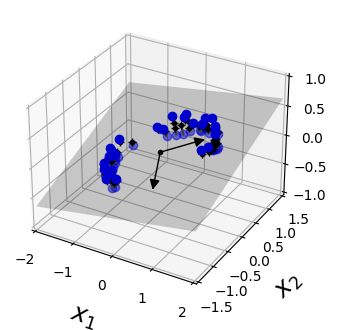

In [12]:
# 3차원 좌표 공간 만들기
fig = plt.figure(figsize=(6, 3.8))
ax = fig.add_subplot(111, projection='3d')

# 주성분 으로 만든 평면보다 아래에 있는 샘플과 위에있는 샘플 구분하기
X3D_above = X[X[:, 2] > X3D_inv[:, 2]]
X3D_below = X[X[:, 2] <= X3D_inv[:, 2]]

# 아래에 있는 샘플 시각화
ax.plot(X3D_below[:, 0], X3D_below[:, 1], X3D_below[:, 2], "bo", alpha=0.5)

# 주성분으로 만든어진 평면 시각화
ax.plot_surface(x1, x2, z, alpha=0.2, color="k")
np.linalg.norm(C, axis=0)

# 중점과 주성분은 화살표로 표시
ax.add_artist(Arrow3D([0, C[0, 0]],[0, C[0, 1]],[0, C[0, 2]], mutation_scale=15, lw=1, arrowstyle="-|>", color="k"))
ax.add_artist(Arrow3D([0, C[1, 0]],[0, C[1, 1]],[0, C[1, 2]], mutation_scale=15, lw=1, arrowstyle="-|>", color="k"))
ax.plot([0], [0], [0], "k.")

# 평면으로 투영선 그리기
for i in range(m):
    if X[i, 2] > X3D_inv[i, 2]:
        ax.plot([X[i][0], X3D_inv[i][0]], [X[i][1], X3D_inv[i][1]], [X[i][2], X3D_inv[i][2]], "k-")
    else:
        ax.plot([X[i][0], X3D_inv[i][0]], [X[i][1], X3D_inv[i][1]], [X[i][2], X3D_inv[i][2]], "-", color="#505050")    
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "k+")
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "k.")

# 위에 있는 샘플 시각화
ax.plot(X3D_above[:, 0], X3D_above[:, 1], X3D_above[:, 2], "bo")

ax.set_xlabel("$x_1$", fontsize=18, labelpad=10)
ax.set_ylabel("$x_2$", fontsize=18, labelpad=10)
ax.set_zlabel("$x_3$", fontsize=18, labelpad=10)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])
plt.show()

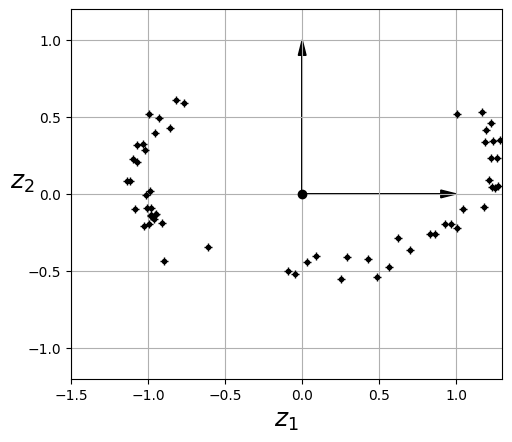

In [13]:
# 투영된 2차원 데이터셋

fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')

ax.plot(X2D[:, 0], X2D[:, 1], "k+")
ax.plot(X2D[:, 0], X2D[:, 1], "k.")
ax.plot([0], [0], "ko")
ax.arrow(0, 0, 0, 1, head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k')
ax.arrow(0, 0, 1, 0, head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k')
ax.set_xlabel("$z_1$", fontsize=18)
ax.set_ylabel("$z_2$", fontsize=18, rotation=0)
ax.axis([-1.5, 1.3, -1.2, 1.2])
ax.grid(True)

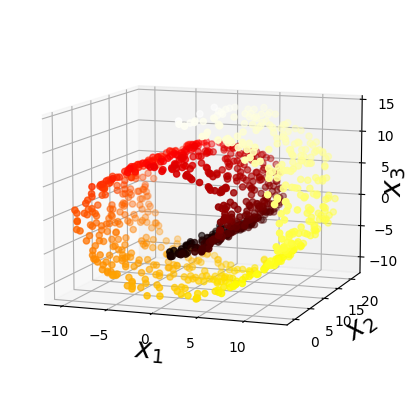

In [14]:
# 스위스 롤 데이터셋 분석

from sklearn.datasets import make_swiss_roll

X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)
axes = [-11.5, 14, -2, 23, -12, 15]

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=t, cmap=plt.cm.hot)
ax.view_init(10, -70)

ax.set_xlabel("$x_1$", fontsize=20, labelpad=0)
ax.set_ylabel("$x_2$", fontsize=20, labelpad=0)
ax.set_zlabel("$x_3$", fontsize=20, labelpad=-5, rotation=0)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

plt.show()

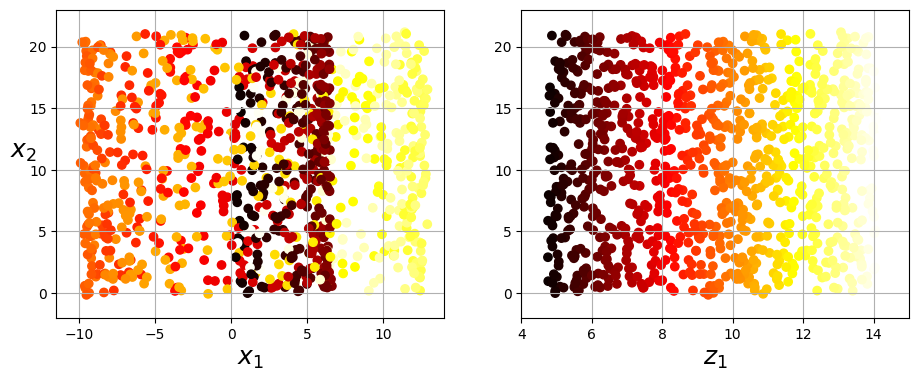

In [15]:
plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.scatter(X[:, 0], X[:, 1], c=t, cmap=plt.cm.hot)
plt.axis(axes[:4])
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$x_2$", fontsize=18, rotation=0)
plt.grid(True)

plt.subplot(122)
plt.scatter(t, X[:, 1], c=t, cmap=plt.cm.hot)
plt.axis([4, 15, axes[2], axes[3]])
plt.xlabel("$z_1$", fontsize=18)
plt.grid(True)

plt.show()

왼쪽의 경우 스위스 롤의 Z축 값을 없애고 그냥 XY평면에 데이터를 투영한 모습이다.

오른쪽은 스위스 롤을 unrolling했을 때의 위치를 표시한 것이다.

왼쪽의 경우를 통해 단순히 투영을 했을 경우 오히려 데이터가 뭉개져서 안좋은 결과가 나올 수도 있다는 것을 볼 수 있다.

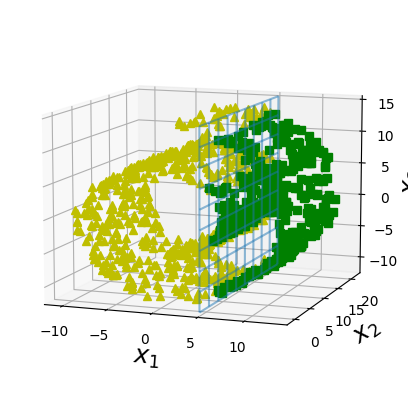

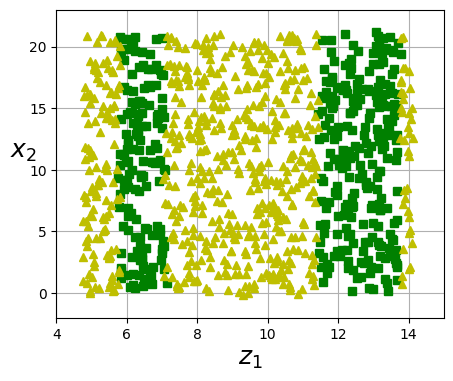

In [16]:
# 저차원 매니폴드 공간이 유효하지 않은 경우 

axes = [-11.5, 14, -2, 23, -12, 15]
x2s = np.linspace(axes[2], axes[3], 10)
x3s = np.linspace(axes[4], axes[5], 10)
x2, x3 = np.meshgrid(x2s, x3s)

fig = plt.figure(figsize=(6, 5))
ax = plt.subplot(111, projection='3d')
positive_class = X[:, 0] > 5
X_pos = X[positive_class]
X_neg = X[~positive_class]
ax.view_init(10, -70)
ax.plot(X_neg[:, 0], X_neg[:, 1], X_neg[:, 2], "y^")
ax.plot_wireframe(5, x2, x3, alpha=0.5)
ax.plot(X_pos[:, 0], X_pos[:, 1], X_pos[:, 2], "gs")
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

fig = plt.figure(figsize=(5, 4))
ax = plt.subplot(111)
plt.plot(t[positive_class], X[positive_class, 1], "gs")
plt.plot(t[~positive_class], X[~positive_class, 1], "y^")
plt.axis([4, 15, axes[2], axes[3]])
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$x_2$", fontsize=18, rotation=0)
plt.grid(True)

plt.show()

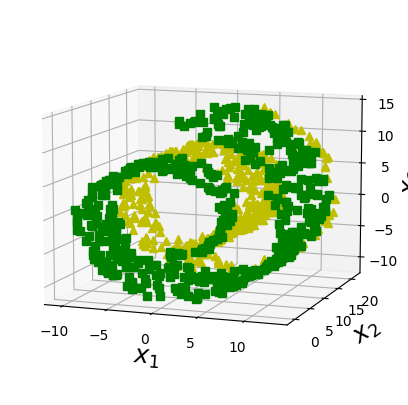

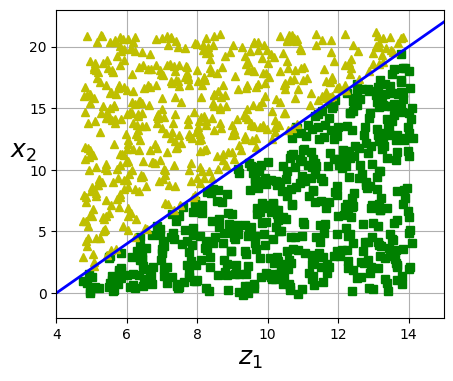

In [17]:
# 저차원 매니폴드 공간이 유효한 경우

fig = plt.figure(figsize=(6, 5))
ax = plt.subplot(111, projection='3d')
positive_class = 2 * (t[:] - 4) > X[:, 1]
X_pos = X[positive_class]
X_neg = X[~positive_class]
ax.view_init(10, -70)
ax.plot(X_neg[:, 0], X_neg[:, 1], X_neg[:, 2], "y^")
ax.plot(X_pos[:, 0], X_pos[:, 1], X_pos[:, 2], "gs")
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])


fig = plt.figure(figsize=(5, 4))
ax = plt.subplot(111)
plt.plot(t[positive_class], X[positive_class, 1], "gs")
plt.plot(t[~positive_class], X[~positive_class, 1], "y^")
plt.plot([4, 15], [0, 22], "b-", linewidth=2)
plt.axis([4, 15, axes[2], axes[3]])
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$x_2$", fontsize=18, rotation=0)
plt.grid(True)

plt.show()

첫 번째 사례처럼 결정 경계가 z축에 평행하게 형성된 경우 3차원 그래프에서는 하나의 평면으로 샘플이 명확하게 구분되는 형태이다.

하지만 이를 2차원 매니폴드 공간으로 펼치면 4개의 결정 경계가 필요해 매우 복잡해졌다.

반면 두 번째 사례의 경우는 3차원 에서는 결정 평면이 매우 복잡한 형태이지만 저차원 매니폴드 공간에서 표현된 형태는 하나의 단순한 직선으로 결정경계가 생겨 단순해진다.

이처럼 저차원 매니폴드로 차원을 축소시키는 것은 항상 더 좋은 결과를 내는것은 아니다.

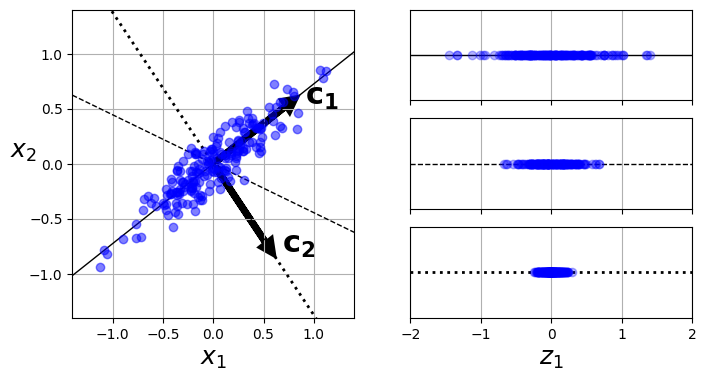

In [18]:
# 축에 따른 분산 보존 차이

angle = np.pi / 5
stretch = 5
m = 200

np.random.seed(3)
X = np.random.randn(m, 2) / 10
X = X.dot(np.array([[stretch, 0],[0, 1]]))
X = X.dot([[np.cos(angle), np.sin(angle)], [-np.sin(angle), np.cos(angle)]])

u1 = np.array([np.cos(angle), np.sin(angle)])
u2 = np.array([np.cos(angle - 2 * np.pi/6), np.sin(angle - 2 * np.pi/6)])
u3 = np.array([np.cos(angle - np.pi/2), np.sin(angle - np.pi/2)])

X_proj1 = X.dot(u1.reshape(-1, 1))
X_proj2 = X.dot(u2.reshape(-1, 1))
X_proj3 = X.dot(u3.reshape(-1, 1))

plt.figure(figsize=(8,4))
plt.subplot2grid((3,2), (0, 0), rowspan=3)
plt.plot([-1.4, 1.4], [-1.4*u1[1]/u1[0], 1.4*u1[1]/u1[0]], "k-", linewidth=1)
plt.plot([-1.4, 1.4], [-1.4*u2[1]/u2[0], 1.4*u2[1]/u2[0]], "k--", linewidth=1)
plt.plot([-1.4, 1.4], [-1.4*u3[1]/u3[0], 1.4*u3[1]/u3[0]], "k:", linewidth=2)
plt.plot(X[:, 0], X[:, 1], "bo", alpha=0.5)
plt.axis([-1.4, 1.4, -1.4, 1.4])
plt.arrow(0, 0, u1[0], u1[1], head_width=0.1, linewidth=5, length_includes_head=True, head_length=0.1, fc='k', ec='k')
plt.arrow(0, 0, u3[0], u3[1], head_width=0.1, linewidth=5, length_includes_head=True, head_length=0.1, fc='k', ec='k')
plt.text(u1[0] + 0.1, u1[1] - 0.05, r"$\mathbf{c_1}$", fontsize=22)
plt.text(u3[0] + 0.1, u3[1], r"$\mathbf{c_2}$", fontsize=22)
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$x_2$", fontsize=18, rotation=0)
plt.grid(True)

plt.subplot2grid((3,2), (0, 1))
plt.plot([-2, 2], [0, 0], "k-", linewidth=1)
plt.plot(X_proj1[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2, 2, -1, 1])
plt.grid(True)

plt.subplot2grid((3,2), (1, 1))
plt.plot([-2, 2], [0, 0], "k--", linewidth=1)
plt.plot(X_proj2[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2, 2, -1, 1])
plt.grid(True)

plt.subplot2grid((3,2), (2, 1))
plt.plot([-2, 2], [0, 0], "k:", linewidth=2)
plt.plot(X_proj3[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.axis([-2, 2, -1, 1])
plt.xlabel("$z_1$", fontsize=18)
plt.grid(True)

plt.show()

위의 그래프를 통해서 c1의 경우 분산을 제일 많이 보존하는 것을 볼 수 있다.

반면 c2의 경우 거의 분산을 보존하지 못하였다.

In [19]:
# mnist데이터의 적절한 차원수 구하기

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

mnist = fetch_openml('mnist_784', version=1, as_frame=False, parser="auto")
mnist.target = mnist.target.astype(np.uint8)
X = mnist["data"]
y = mnist["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [20]:
# 분산을 95%로 유지하는데 필요한 최소 차원의 수 계산

pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1
d

154

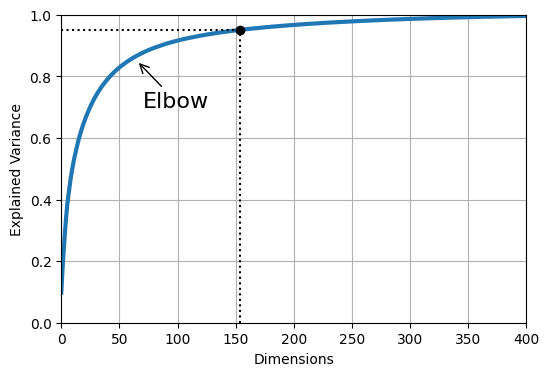

In [21]:
# 차원 수에 대한 함수

plt.figure(figsize=(6,4))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 400, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")
plt.annotate("Elbow", xy=(65, 0.85), xytext=(70, 0.7),
             arrowprops=dict(arrowstyle="->"), fontsize=16)
plt.grid(True)
plt.show()

In [22]:
# mnist 데이터 차원 축소

pca = PCA(n_components=d)
X_reduced = pca.fit_transform(X_train)
X_recovered = pca.inverse_transform(X_reduced)

In [23]:
import math

def plot_digits(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    n_rows = math.ceil(len(instances) / images_per_row)

    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

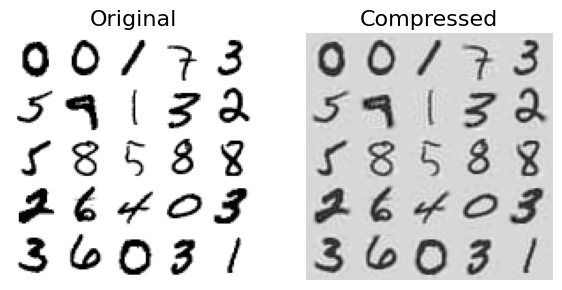

In [24]:
plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.title("Original", fontsize=16)
plt.subplot(122)
plot_digits(X_recovered[::2100])
plt.title("Compressed", fontsize=16)
plt.show()

왼쪽은 원본 데이터이고 오른쪽은 차원 축소 후 다시 복원한 데이터의 그림이다.

이미지를 보면 약간 흐릿하여 데이터의 손실이 있던것을 확인할 수 있다.

그래도 대부분 온전하게 보존 되었음을 알 수 있다.

In [25]:
X_reduced_pca = X_reduced

In [26]:
# 랜덤 PCA

rnd_pca = PCA(n_components=154, svd_solver="randomized", random_state=42)
X_reduced = rnd_pca.fit_transform(X_train)

In [27]:
# 점진적 PCA

from sklearn.decomposition import IncrementalPCA

count = 0
n_batches = 100
inc_pca = IncrementalPCA(n_components=154)
for X_batch in np.array_split(X_train, n_batches):
    count += 1
    if count % 10 == 0:
        print(f"{count // 10}0 % done")
    inc_pca.partial_fit(X_batch)

X_reduced_inc_pca = inc_pca.transform(X_train)

10 % done
20 % done
30 % done
40 % done
50 % done
60 % done
70 % done
80 % done
90 % done
100 % done


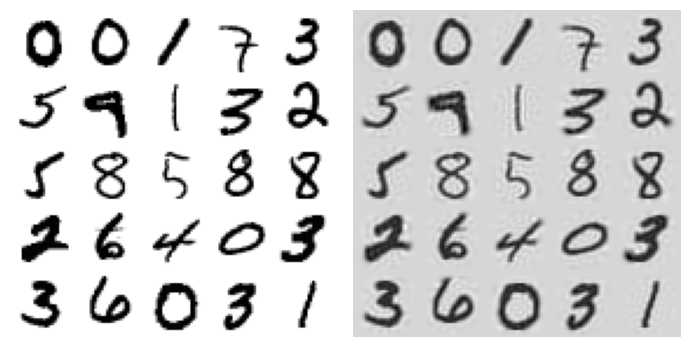

In [28]:
X_recovered_inc_pca = inc_pca.inverse_transform(X_reduced_inc_pca)
plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.subplot(122)
plot_digits(X_recovered_inc_pca[::2100])
plt.tight_layout()

In [29]:
np.allclose(pca.mean_, inc_pca.mean_)

True

In [30]:
np.allclose(X_reduced_pca, X_reduced_inc_pca)

False

점진적 PCA또한 PCA와 동일하게 약간의 데이터 손실이 있지만 대부분 잘 보존이 되었음을 알 수 있다.

점진적 PCA와 일반 PCA를 비교해보면 평균은 같은 것을 볼 수 있다.

하지만 두 개가 완전히 동일한 것은 아니다.

### memmap

메모리 매핑 배열은 데이터 세트가 많아 디스크가 많은 파일에 저장되어 있는 것처럼 접근할 수 있게 된다.

즉, 전체 데이터를 메모리에 로드하지 않는 파일의 일부 또는 필요한 부분에 대한 작업을 수행할 수 있어 메모리에 있는 디스플레이 모듈을 사용할 때 유용하다.

In [31]:
filename = "my_mnist.data"
m, n = X_train.shape

X_mm = np.memmap(filename, dtype='float32', mode='write', shape=(m, n))
X_mm[:] = X_train

In [55]:
del X_mm

In [33]:
# 저장된 메모리를 이용해 매핑을 하여 훈련 데이터를 학습하였다

X_mm = np.memmap(filename, dtype="float32", mode="readonly", shape=(m, n))

batch_size = m // n_batches
inc_pca = IncrementalPCA(n_components=154, batch_size=batch_size)
inc_pca.fit(X_mm)

IncrementalPCA(batch_size=525, n_components=154)

In [64]:
# PCA의 종류별로 시간 복잡도 측정 - 주성분 개수가 2, 10, 154개일 때

import time

for n_components in (2, 10, 154):
    print("n_components =", n_components)
    regular_pca = PCA(n_components=n_components, svd_solver="full")
    inc_pca = IncrementalPCA(n_components=n_components, batch_size=500)
    rnd_pca = PCA(n_components=n_components, random_state=42, svd_solver="randomized")

    for pca in (regular_pca, inc_pca, rnd_pca):
        t1 = time.time()
        pca.fit(X_train)
        t2 = time.time()
        print("    {}: {:.1f} 초".format(type(pca).__name__, t2 - t1))

n_components = 2
    PCA: 4.2 초
    IncrementalPCA: 15.9 초
    PCA: 0.9 초
n_components = 10
    PCA: 4.1 초
    IncrementalPCA: 16.0 초
    PCA: 1.3 초
n_components = 154
    PCA: 4.3 초
    IncrementalPCA: 23.1 초
    PCA: 2.9 초


랜덤 PCA은 확률적 알고리즘을 이용해 처음 d개의 주성분에 대한 근사값을 찾기 때문에 시간 복잡도가 낮아 가장 빠른 것을 볼 수 있다.

IncrementalPCA의 경우는 배치단위로 하기 때문에 많은 반복이 필요해서 시간이 오래 걸린것을 볼 수 있다.

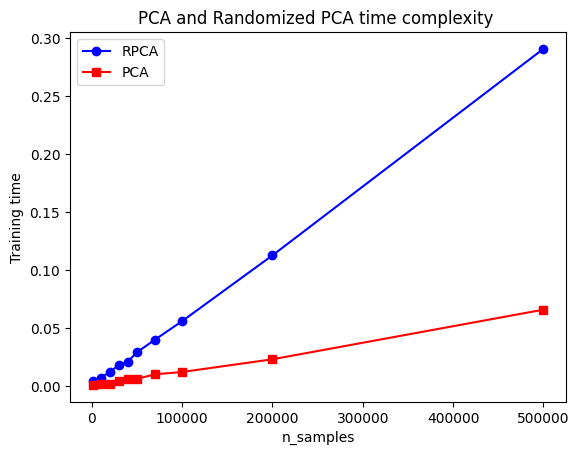

In [65]:
# 샘플의 수에 따른 랜덤PCA와 PCA의 소요 시간 차이

times_rpca = []
times_pca = []
sizes = [1000, 10000, 20000, 30000, 40000, 50000, 70000, 100000, 200000, 500000]
for n_samples in sizes:
    X = np.random.randn(n_samples, 5)
    pca = PCA(n_components=2, svd_solver="randomized", random_state=42)
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_rpca.append(t2 - t1)
    pca = PCA(n_components=2, svd_solver="full")
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_pca.append(t2 - t1)

plt.plot(sizes, times_rpca, "b-o", label="RPCA")
plt.plot(sizes, times_pca, "r-s", label="PCA")
plt.xlabel("n_samples")
plt.ylabel("Training time")
plt.legend(loc="upper left")
plt.title("PCA and Randomized PCA time complexity ")
plt.show()

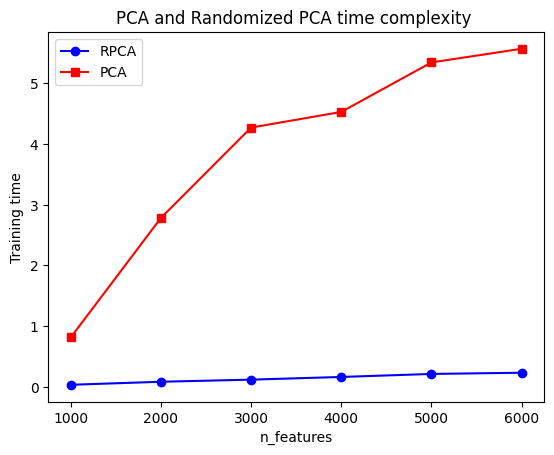

In [37]:
# 특성의 수에 따른 랜덤PCA와 PCA의 소요 시간 차이

times_rpca = []
times_pca = []
sizes = [1000, 2000, 3000, 4000, 5000, 6000]
for n_features in sizes:
    X = np.random.randn(2000, n_features)
    pca = PCA(n_components=2, random_state=42, svd_solver="randomized")
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_rpca.append(t2 - t1)
    pca = PCA(n_components=2, svd_solver="full")
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_pca.append(t2 - t1)

plt.plot(sizes, times_rpca, "b-o", label="RPCA")
plt.plot(sizes, times_pca, "r-s", label="PCA")
plt.xlabel("n_features")
plt.ylabel("Training time")
plt.legend(loc="upper left")
plt.title("PCA and Randomized PCA time complexity ")
plt.show()

샘플의 수가 많으면 전통적인 PCA가 더 적은 시간이 걸리는 것을 볼 수 있다.

왜냐하면 랜덤PCA의 경우 확률적인 방법을 사용하므로 샘플의 수가 많아질수록 더 많은 무작위 샘플링을 수행하여 주성분을 추정해야 하기 때문이다.

결과적으로 계산 시간이 증가하게 된다.

반면에 특성의 수가 많은 경우 랜덤 PCA는 데이터의 일부 특성만 사용하여 주성분을 추출하기 때문에 계산 및 메모리 요구량을 크게 줄일 수 있다.

따라서 이러한 경우에는 랜덤 PCA를 사용하는 것이 더 유리하다.

In [80]:
# 커널 PCA

from sklearn.decomposition import KernelPCA

X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)
rbf_pca = KernelPCA(n_components=2, kernel="rbf", gamma=0.04)
X_reduced = rbf_pca.fit_transform(X)

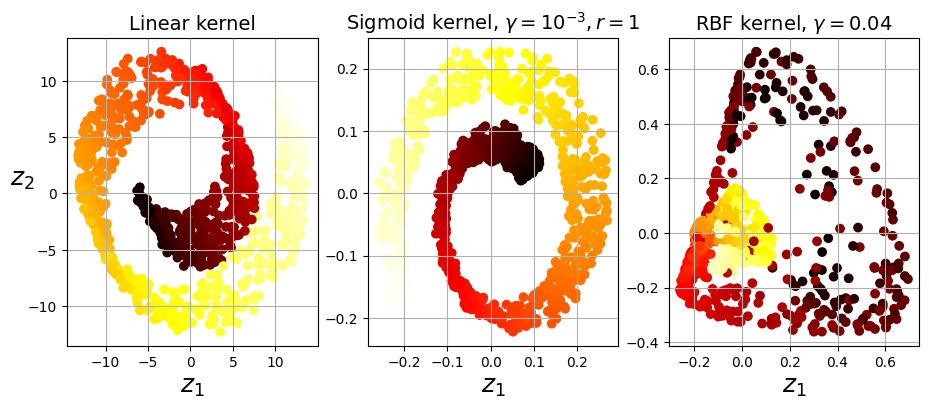

In [87]:
# 선형, 가우시안RDF, 시그모이드 함수를 이용한 커널PCA로 스위스 롤 차원 축소

lin_pca = KernelPCA(n_components=2, kernel="linear", fit_inverse_transform=True)
sig_pca = KernelPCA(n_components=2, kernel="sigmoid", gamma=0.001, coef0=1, fit_inverse_transform=True)
rbf_pca = KernelPCA(n_components=2, kernel="rbf", gamma=0.0433, fit_inverse_transform=True)

plt.figure(figsize=(11, 4))
for subplot, pca, title in ((131, lin_pca, "Linear kernel"), (132, sig_pca, "Sigmoid kernel, $\gamma=10^{-3}, r=1$"), (133, rbf_pca, "RBF kernel, $\gamma=0.04$")):
    X_reduced = pca.fit_transform(X)
    if subplot == 133:
        X_reduced_rbf = X_reduced
    
    plt.subplot(subplot)
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

plt.show()

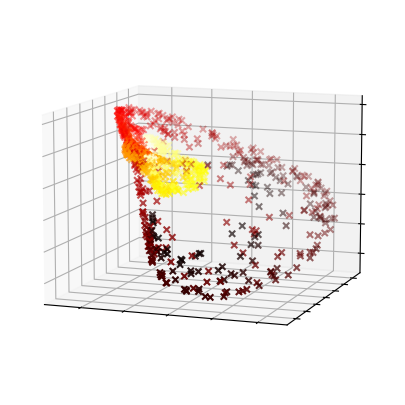

In [88]:
# RBF커널 PCA의 재구성 오차

plt.figure(figsize=(6, 5))

X_inverse = rbf_pca.inverse_transform(X_reduced_rbf)

ax = plt.subplot(111, projection='3d')
ax.view_init(10, -70)
ax.scatter(X_inverse[:, 0], X_inverse[:, 1], X_inverse[:, 2], c=t, cmap=plt.cm.hot, marker="x")
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_zlabel("")
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])

plt.show()

In [91]:
# 그리드 탐색을 통해 하아퍼파라미터 튜닝

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

y = t > 6.9

clf = Pipeline([
        ("kpca", KernelPCA(n_components=2)),
        ("log_reg", LogisticRegression(solver="lbfgs"))
    ])

param_grid = [{
        "kpca__gamma": np.linspace(0.03, 0.05, 10),
        "kpca__kernel": ["rbf", "sigmoid"]
    }]

grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X, y)
grid_search.best_params_

{'kpca__gamma': 0.043333333333333335, 'kpca__kernel': 'rbf'}

그리드 탐색을 통해 최적의 gamma값은 0.043이고 kernel은 rbf커널일 때 이다

In [92]:
# 얻은 최적의 하이퍼파라미터로 학습

from sklearn.metrics import mean_squared_error

rbf_pca = KernelPCA(n_components=2, kernel="rbf", gamma=0.0433,
                    fit_inverse_transform=True)
X_reduced = rbf_pca.fit_transform(X)
X_preimage = rbf_pca.inverse_transform(X_reduced)
mean_squared_error(X, X_preimage)

32.78630879576615

In [93]:
# LLE

from sklearn.manifold import LocallyLinearEmbedding

X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=41)
lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
X_reduced = lle.fit_transform(X)

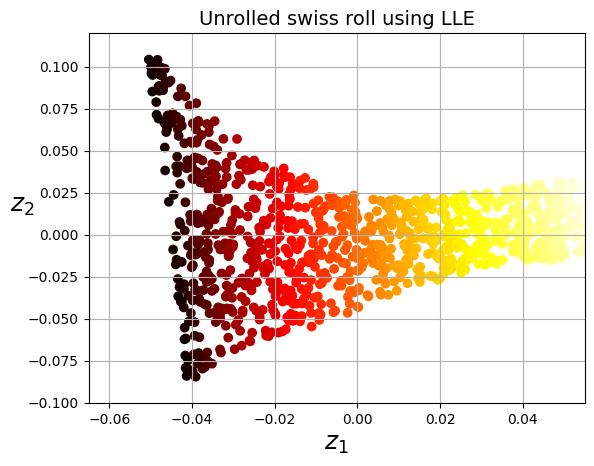

In [95]:
plt.title("Unrolled swiss roll using LLE", fontsize=14)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.axis([-0.065, 0.055, -0.1, 0.12])
plt.grid(True)

plt.show()

In [50]:
# 다차원 스케일링을 통한 차원 축소

from sklearn.manifold import MDS

mds = MDS(n_components=2, random_state=42, normalized_stress="auto")
X_reduced_mds = mds.fit_transform(X)

In [51]:
# Isomap을 이용한 차원 축소

from sklearn.manifold import Isomap

isomap = Isomap(n_components=2)
X_reduced_isomap = isomap.fit_transform(X)

In [52]:
# t-SNE을 이용한 차원 축소

from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_reduced_tsne = tsne.fit_transform(X)

In [53]:
# 선형 판별 분석을 이용한 차원 축소

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(n_components=2)
X_mnist = mnist["data"]
y_mnist = mnist["target"]
lda.fit(X_mnist, y_mnist)
X_reduced_lda = lda.transform(X_mnist)

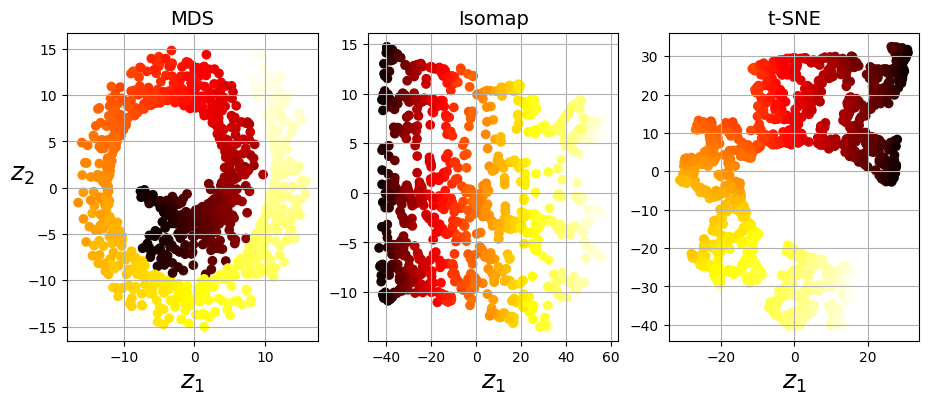

In [54]:
# 다양한 차원 축소 기법을 통해 스위스 롤의 차원 축소

titles = ["MDS", "Isomap", "t-SNE"]

plt.figure(figsize=(11,4))

for subplot, title, X_reduced in zip((131, 132, 133), titles,
                                     (X_reduced_mds, X_reduced_isomap, X_reduced_tsne)):
    plt.subplot(subplot)
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

plt.show()